# Parameter tuning

### Import libraries

In [1]:
import copy
from pathlib import Path
project_root = Path.cwd().resolve().parents[1]
import ray 
ray.shutdown() 
ray.init(runtime_env={"working_dir": project_root})
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytagi import Normalizer
import pytagi.metric as metric


/opt/miniconda3/envs/canari/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-26 15:10:16,818	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-05-26 15:10:17,301	INFO worker.py:1852 -- Started a local Ray instance.
2025-05-26 15:10:17,944	INFO packaging.py:575 -- Creating a file package for local module '/Users/vuongdai/GitHub/canari'.
2025-05-26 15:10:17,964	WARNING packaging.py:417 -- File /Users/vuongdai/GitHub/canari/.git/objects/92/45ee127ddd1bf42655a9cbd1f0de336db6289d is very large (10.22MiB). Consider adding this file to the 'excludes' list to skip uploading it: `ray.init(..., runtime_env={'excludes': ['/Users/vuongdai/GitHub/canari/.git/objects/92/45ee127ddd1bf42655a9cbd1f0de336db6289d']}

### Import from Canari

In [2]:
from canari import (
    DataProcess,
    Model,
    SKF,
    ModelOptimizer,
    SKFOptimizer,
    plot_data,
    plot_prediction,
    plot_states,
    plot_skf_states,
)
from canari.component import LocalTrend, LocalAcceleration, LstmNetwork, WhiteNoise

2025-05-26 15:10:21,589	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


### Read data

In [3]:
project_root = Path.cwd().resolve().parents[1]
data_file = str(project_root / "data/toy_time_series/sine.csv")
df = pd.read_csv(data_file, skiprows=1, delimiter=",", header=None)
# Add synthetic anomaly to data
trend = np.linspace(0, 0, num=len(df))
time_anomaly = 120
new_trend = np.linspace(0, 1, num=len(df) - time_anomaly)
trend[time_anomaly:] = trend[time_anomaly:] + new_trend
df = df.add(trend, axis=0)
#
data_file_time = str(project_root / "data/toy_time_series/sine_datetime.csv")
time_index = pd.read_csv(data_file_time, skiprows=1, delimiter=",", header=None)
time_index = pd.to_datetime(time_index[0])
df.index = time_index
df.index.name = "time"
df.columns = ["values"]

### Data preprocess

In [4]:
output_col = [0]
data_processor = DataProcess(
    data=df,
    time_covariates=["hour_of_day"],
    train_split=0.4,
    validation_split=0.1,
    output_col=output_col,
)
train_data, validation_data, test_data, all_data = data_processor.get_splits()
data_processor.data.head()

,values,hour_of_day
time,,
2000-01-03 00:00:00,0.00,0.0
2000-01-03 01:00:00,-0.26,1.0
2000-01-03 02:00:00,-0.50,2.0
2000-01-03 03:00:00,-0.71,3.0
2000-01-03 04:00:00,-0.87,4.0


### A. Optimize model's parameters

### A.1. Parameter space

In [5]:
param_space = {
    "look_back_len": [10, 30],
    "sigma_v": [1e-3, 2e-1],
}

### A.2. Model as a function of parameters

In [6]:
def initialize_model(param, train_data, validation_data):
    model = Model(
        LocalTrend(),
        LstmNetwork(
            look_back_len=param["look_back_len"],
            num_features=2,
            num_layer=1,
            num_hidden_unit=50,
            device="cpu",
            manual_seed=1,
        ),
        WhiteNoise(std_error=param["sigma_v"]),
    )
    model.auto_initialize_baseline_states(train_data["y"][0:24])

    # Training
    num_epoch = 50
    for epoch in range(num_epoch):
        (mu_validation_preds, std_validation_preds, states) = model.lstm_train(
            train_data=train_data,
            validation_data=validation_data,
        )

        # Unstandardize the predictions
        mu_validation_preds_unnorm = Normalizer.unstandardize(
            mu_validation_preds,
            data_processor.scale_const_mean[data_processor.output_col],
            data_processor.scale_const_std[data_processor.output_col],
        )

        std_validation_preds_unnorm = Normalizer.unstandardize_std(
            std_validation_preds,
            data_processor.scale_const_std[data_processor.output_col],
        )

        validation_obs = data_processor.get_data("validation").flatten()
        validation_log_lik = metric.log_likelihood(
            prediction=mu_validation_preds_unnorm,
            observation=validation_obs,
            std=std_validation_preds_unnorm,
        )

        model.early_stopping(
            evaluate_metric=-validation_log_lik,
            current_epoch=epoch,
            max_epoch=num_epoch,
        )
        model.metric_optim = model.early_stop_metric

        if epoch == model.optimal_epoch:
            mu_validation_preds_optim = mu_validation_preds.copy()
            std_validation_preds_optim = std_validation_preds.copy()
            states_optim = copy.copy(states)

        model.set_memory(states=states, time_step=0)
        if model.stop_training:
            break


    return model, states_optim, mu_validation_preds_optim, std_validation_preds_optim


### A.3. Define optimizer

In [7]:
model_optimizer = ModelOptimizer(
    model=initialize_model,
    param_space=param_space,
    train_data=train_data,
    validation_data = validation_data,
    num_optimization_trial=20,
)
model_optimizer.optimize()

#  1/20 - Metric: -1.438 - Parameter: {'look_back_len': 13, 'sigma_v': 0.05764302800736558}
#  2/20 - Metric: -1.201 - Parameter: {'look_back_len': 19, 'sigma_v': 0.06640304546555219}
#  3/20 - Metric: -0.833 - Parameter: {'look_back_len': 21, 'sigma_v': 0.15202902549685612}
#  4/20 - Metric: -1.105 - Parameter: {'look_back_len': 18, 'sigma_v': 0.10095289042645582}
#  5/20 - Metric: -0.920 - Parameter: {'look_back_len': 26, 'sigma_v': 0.09496199409391315}
#  6/20 - Metric: -0.775 - Parameter: {'look_back_len': 16, 'sigma_v': 0.17781523120365042}
#  7/20 - Metric: -1.050 - Parameter: {'look_back_len': 24, 'sigma_v': 0.010278831475681417}
#  8/20 - Metric: -1.696 - Parameter: {'look_back_len': 10, 'sigma_v': 0.003142796982299852}
#  9/20 - Metric: -1.050 - Parameter: {'look_back_len': 18, 'sigma_v': 0.11507554172817432}
# 10/20 - Metric: -0.703 - Parameter: {'look_back_len': 20, 'sigma_v': 0.19694609958492723}
# 11/20 - Metric: -1.027 - Parameter: {'look_back_len': 24, 'sigma_v': 0.03463

2025-05-26 15:10:39,354	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/vuongdai/ray_results/Model_optimizer' in 0.0088s.


# 20/20 - Metric: -1.560 - Parameter: {'look_back_len': 13, 'sigma_v': 0.025250126126804488}
-----
Optimal parameters at trial #13: {'look_back_len': 10, 'sigma_v': 0.0027068097572160053}
-----


### A.4 Get optimal model

In [8]:
param_optim = model_optimizer.get_best_param()
model_optim, states_optim, mu_validation_preds, std_validation_preds = initialize_model(param_optim, train_data, validation_data)
model_optim_dict = model_optim.get_dict()

### A.5 Hidden states and predictions

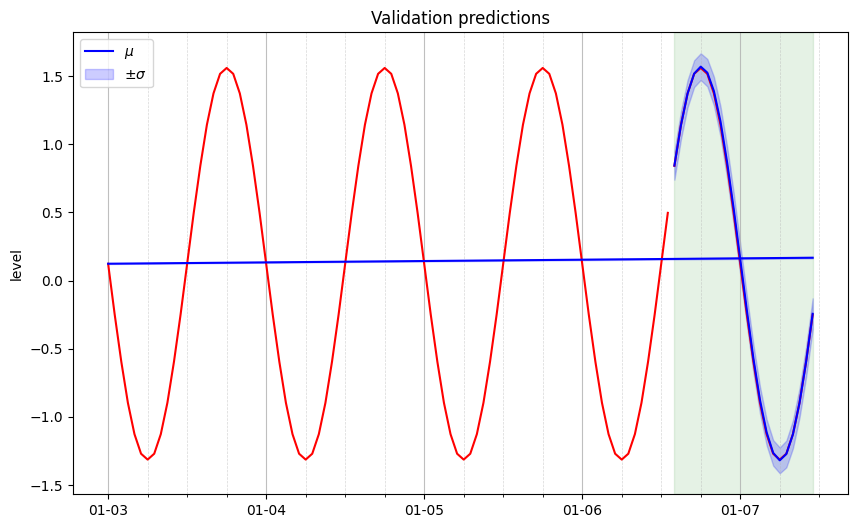

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_data(
    data_processor=data_processor,
    standardization=True,
    plot_test_data=False,
    plot_column=output_col,
    test_label="y",
)
plot_prediction(
    data_processor=data_processor,
    mean_validation_pred=mu_validation_preds,
    std_validation_pred=std_validation_preds,
    validation_label=[r"$\mu$", f"$\pm\sigma$"],
)
plot_states(
    data_processor=data_processor,
    states=states_optim,
    standardization=True,
    states_to_plot=["level"],
    sub_plot=ax,
)
plt.legend()
plt.title("Validation predictions")
plt.show()

### B. Optimize Switching Kalman Filter's (SKF) parameters

### B.1. Parameter space

In [10]:
slope_upper_bound = 5e-2
slope_lower_bound = 1e-3
skf_param = {
    "std_transition_error": [1e-6, 1e-3],
    "norm_to_abnorm_prob": [1e-6, 1e-3],
    "slope": [slope_lower_bound, slope_upper_bound],
}

### B.2. SKF model as a function of parameters

In [11]:
def initialize_skf(skf_param, model_param: dict):
    norm_model = Model.load_dict(model_param)
    abnorm_model = Model(
        LocalAcceleration(),
        LstmNetwork(),
        WhiteNoise(),
    )
    skf = SKF(
        norm_model=norm_model,
        abnorm_model=abnorm_model,
        std_transition_error=skf_param["std_transition_error"],
        norm_to_abnorm_prob=skf_param["norm_to_abnorm_prob"],
    )
    return skf

### B.3. Optimizer

In [12]:
skf_optimizer = SKFOptimizer(
    initialize_skf=initialize_skf,
    param_space=skf_param,
    model_param=model_optim_dict,
    data=train_data,
    num_synthetic_anomaly=50,
    num_optimization_trial=40,
)
skf_optimizer.optimize()

#  1/40 - Metric: 2.042 - Detection rate: 0.00 - False rate: 0.00 - False alarm in train: No - Parameter: {'std_transition_error': 3.408091768777799e-06, 'norm_to_abnorm_prob': 0.00033059219041223735, 'slope': 0.008402290360458708}
#  2/40 - Metric: 1.108 - Detection rate: 1.00 - False rate: 0.00 - False alarm in train: No - Parameter: {'std_transition_error': 0.00014753130092851492, 'norm_to_abnorm_prob': 0.00028983954221501894, 'slope': 0.021512593139449344}
#  3/40 - Metric: 2.006 - Detection rate: 0.00 - False rate: 0.00 - False alarm in train: No - Parameter: {'std_transition_error': 0.0003426353053685276, 'norm_to_abnorm_prob': 0.00010830778297133414, 'slope': 0.0011979902708257415}
#  4/40 - Metric: 2.009 - Detection rate: 0.00 - False rate: 0.00 - False alarm in train: No - Parameter: {'std_transition_error': 3.711958898505293e-06, 'norm_to_abnorm_prob': 0.00019949200304126497, 'slope': 0.0017034524794309637}
#  5/40 - Metric: 2.012 - Detection rate: 0.00 - False rate: 0.00 - F

2025-05-26 15:11:16,005	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/vuongdai/ray_results/SKF_optimizer' in 0.0114s.


# 40/40 - Metric: 0.950 - Detection rate: 0.92 - False rate: 0.00 - False alarm in train: No - Parameter: {'std_transition_error': 0.00021143898730368083, 'norm_to_abnorm_prob': 0.00011122789596118995, 'slope': 0.006091122382854389}
-----
Optimal parameters at trial #38: {'std_transition_error': 2.333323218088839e-05, 'norm_to_abnorm_prob': 0.00014477787352995747, 'slope': 0.007022024949069811}
-----


### B.4. Get optimal SKF

In [13]:
# Get optimal model
skf_param = skf_optimizer.get_best_param()
skf_optim = initialize_skf(skf_param, model_optim_dict)

### B.5. Anomaly detection

In [14]:
filter_marginal_abnorm_prob, states = skf_optim.filter(data=all_data)
smooth_marginal_abnorm_prob, states = skf_optim.smoother()

### B.6. Hidden states and proability of anomalies

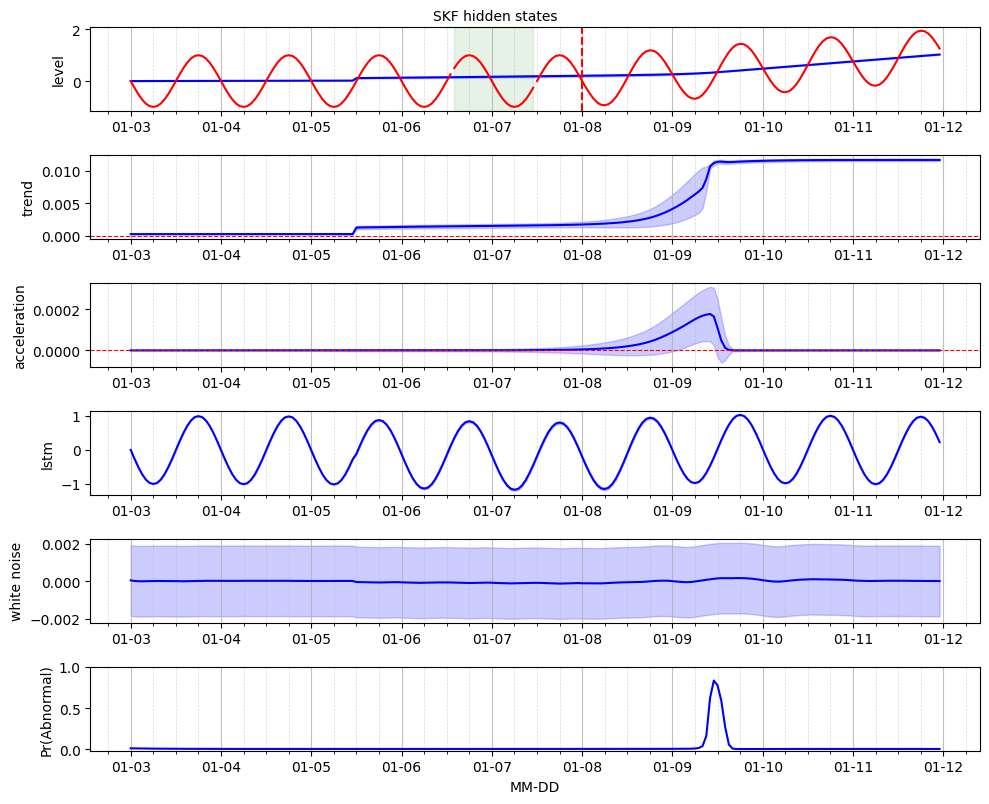

In [16]:
fig, ax = plot_skf_states(
    data_processor=data_processor,
    states=states,
    states_type="smooth",
    model_prob=filter_marginal_abnorm_prob,
)
ax[0].axvline(
    x=data_processor.data.index[time_anomaly],
    color="r",
    linestyle="--",
)
fig.suptitle("SKF hidden states", fontsize=10, y=1)
ax[-1].set_xlabel("MM-DD") 
plt.show()